# **1 - Perkenalan**

- Grup        : Study Group 1

- Nama Anggota:
  - Efitri Apriliyan
  - Suma Andru 
  - Afifah Rahma Tifani

- Dataset   : Struk dan Resi Belanja
- Objective : Receipt to Text using CV2 and PyTesseract


----------------------------------------------------------------------------------



**Latar Belakang**

Selama ini, proses untuk melakukan klaim/reimbursment ke perusahaan cukup memakan waktu karena prosesnya masih manual. Automasi reimbursement akan memberikan keuntungan pada semua pihak, baik pihak yang mengajukan klaim dan perusahaan penerima klaim. Bagi perusahaan, hal ini memudahkan kinerja dan mempersingkat waktu. Uang yang akan diklaim oleh pengaju juga akan cepat kembali.

Pada project ini, kita akan membuat model untuk mempersingkat klaim yaitu hanya dengan meng-upload struk/nota/resi. Text dalam foto struk akan terekstrak langsung ke dalam bentuk tabel.

# **2 - Import Libraries**


In [39]:
from skimage.filters import threshold_local
from PIL import Image

In [40]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [41]:
! pip install Pillow
! pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
!pip -vvv install prettytable

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import re

import warnings
warnings.filterwarnings('ignore')

import pytesseract
from PIL import ImageEnhance, ImageFilter, Image
from pytesseract import Output

import prettytable
from prettytable import PrettyTable

# **3 - Image Preprocessing**

In [44]:
from skimage.filters import threshold_local
from PIL import Image

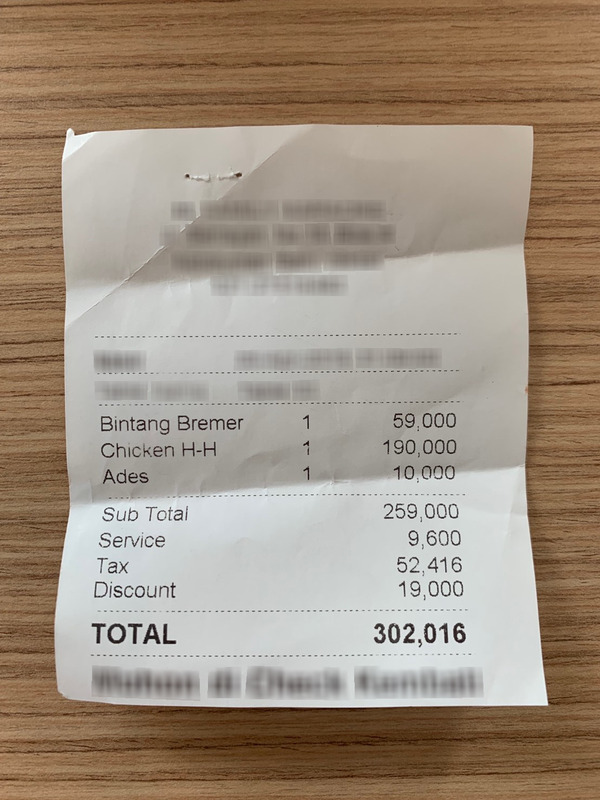

In [45]:
# Filename
file_name = 'receipt_00003.png'

# Open Image
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [46]:
# Function to plot image rgb
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [47]:
# Function to plot gray image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

## Downscale the image

In [48]:
# Function to resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [49]:
#  read image with cv2 
image = cv2.imread(file_name)

# Downscale image 
resize_ratio = 1000 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

## Binarization

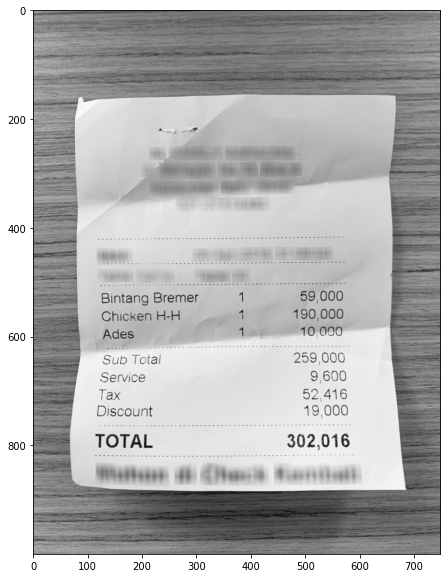

In [50]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

## Noise Removal

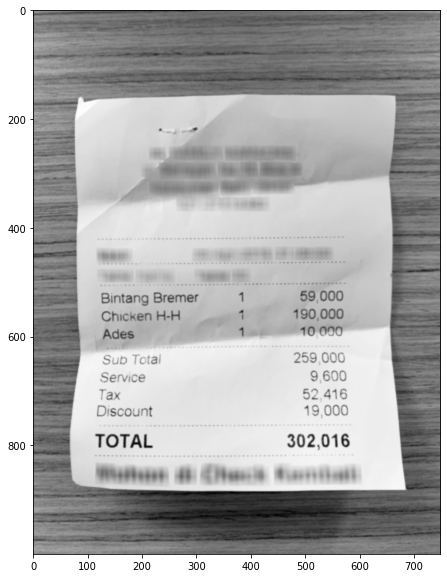

In [51]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 1)
plot_gray(blurred)
blurred = cv2.medianBlur(blurred,7)


## Erosion and Dilation

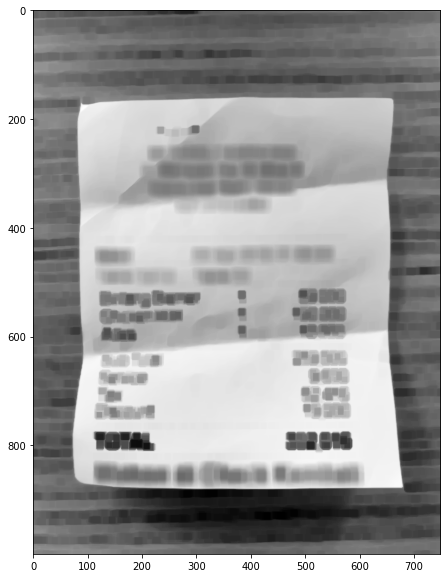

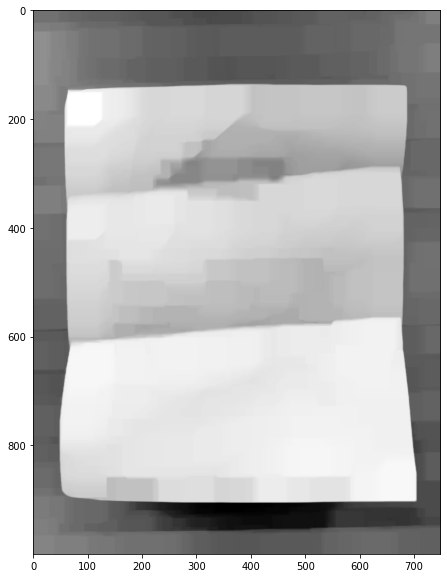

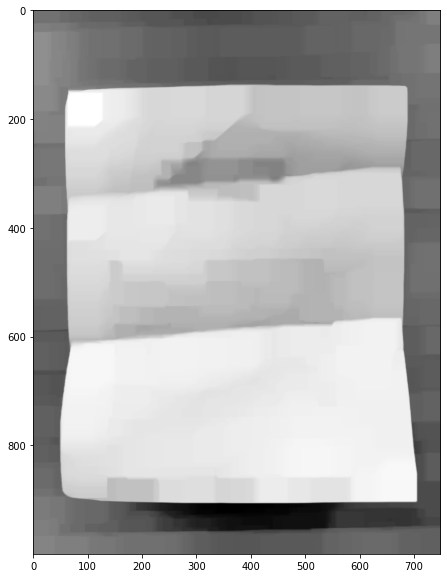

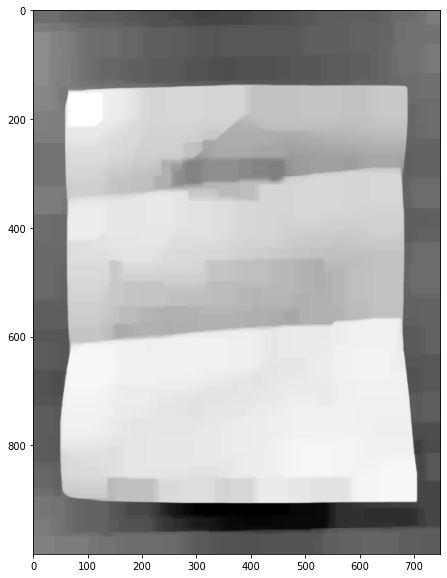

In [52]:
#erosion
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
erosion = cv2.erode(blurred,kernel,iterations = 1)
plot_gray(erosion)

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
dilated = cv2.dilate(erosion, rectKernel)
plot_gray(dilated)

opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, rectKernel2)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel2)

plot_gray(opening)
plot_gray(closing)

## Edge and Contour Detection

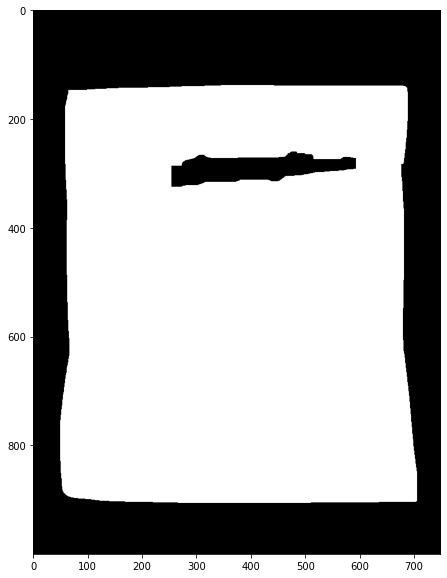

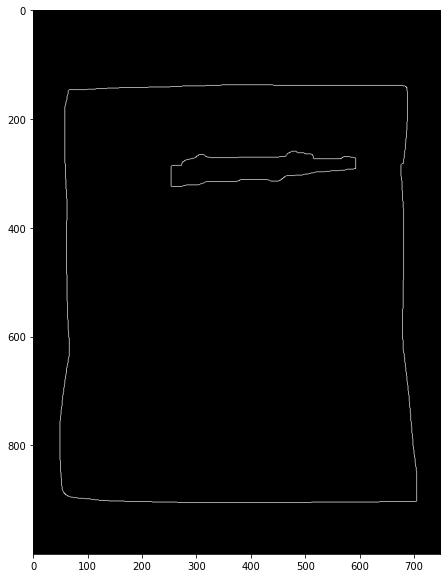

In [53]:
(thresh, blackAndWhiteImage) = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plot_gray(blackAndWhiteImage)

edged = cv2.Canny(blackAndWhiteImage, 30, 30, apertureSize=3)
plot_gray(edged)

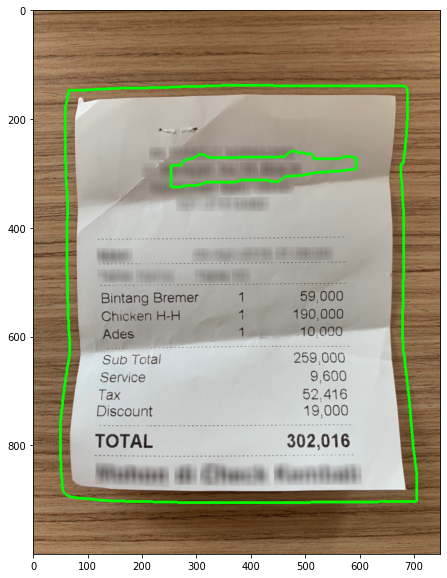

In [54]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(blackAndWhiteImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

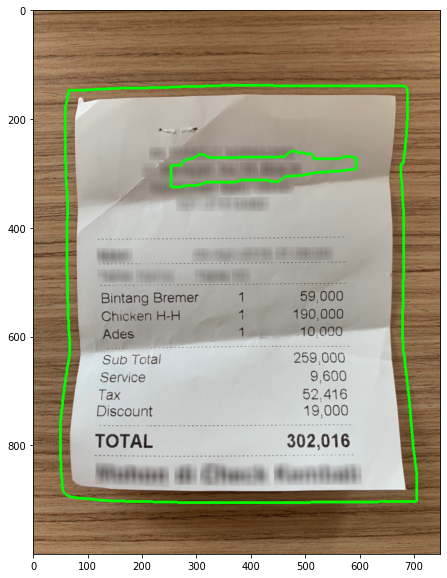

In [55]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [56]:
# approximate contour
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [57]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

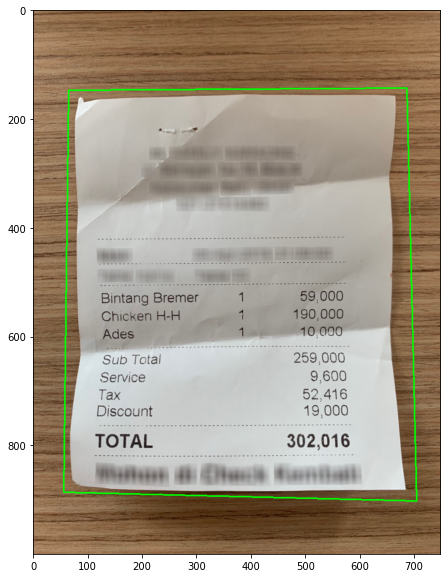

In [58]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

## Scan the image

In [59]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [60]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

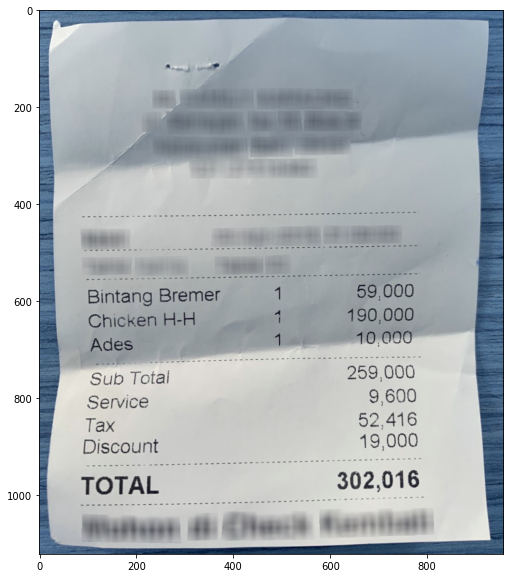

In [61]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

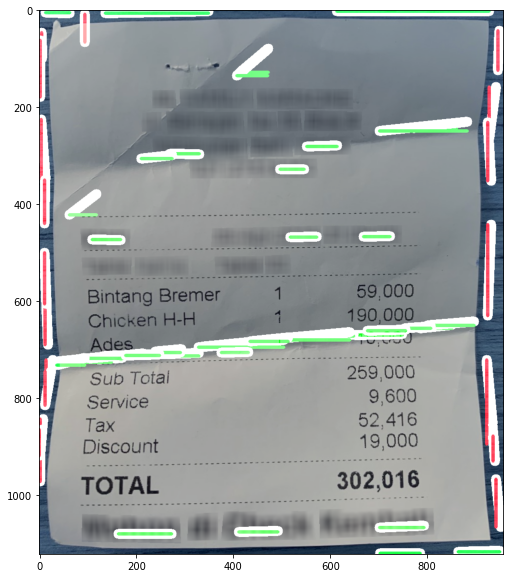

In [62]:
temp_image = cv2.cvtColor(scanned.copy(), cv2.COLOR_BGR2RGB)


blurred = cv2.GaussianBlur(temp_image, (5, 5), 1)

blurred = cv2.medianBlur(blurred,7)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
erosion = cv2.erode(blurred,kernel,iterations = 1)


rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
dilated = cv2.dilate(erosion, rectKernel)


opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, rectKernel2)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel2)

edged = cv2.Canny(opening, 30, 30, apertureSize=3)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 600  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

line_image = np.copy(temp_image) * 0  # creating a blank to draw lines on

minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edged, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),20)
        diff_x = abs(x1 - x2)
        diff_y = abs(y1 - y2)
        if(diff_y <= diff_x):
            cv2.line(line_image,(x1,y1),(x2,y1),(0,255,0),5)
        else:
            cv2.line(line_image,(x1,y1),(x1,y2),(0,0,255),5)
        
        #cv2.putText(temp_image, str(diff_x) + ' | ' + str(diff_y), (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 10, 100), 2, cv2.LINE_AA)
        

lines_edges = cv2.addWeighted(temp_image, 0.8, line_image, 1, 0)


plot_rgb(lines_edges)

## BW Scanner

In [63]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

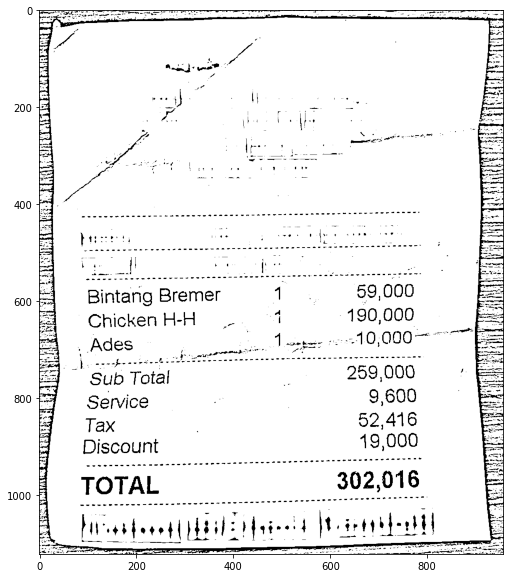

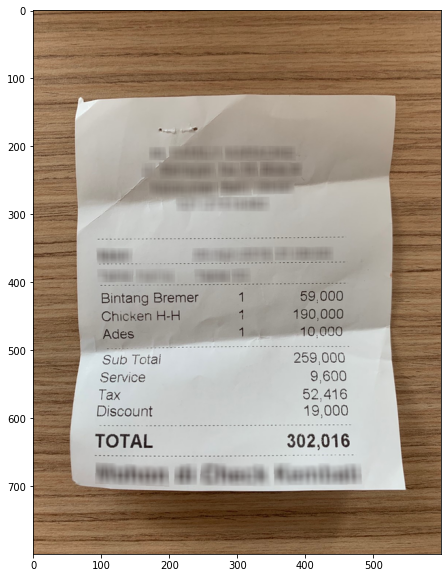

In [64]:
result = bw_scanner(scanned)
plot_gray(result)
plot_gray(img)

In [65]:
# Save output results

output = Image.fromarray(result)
output.save('result.png')

# **4 - Image to Text with Tesseract**

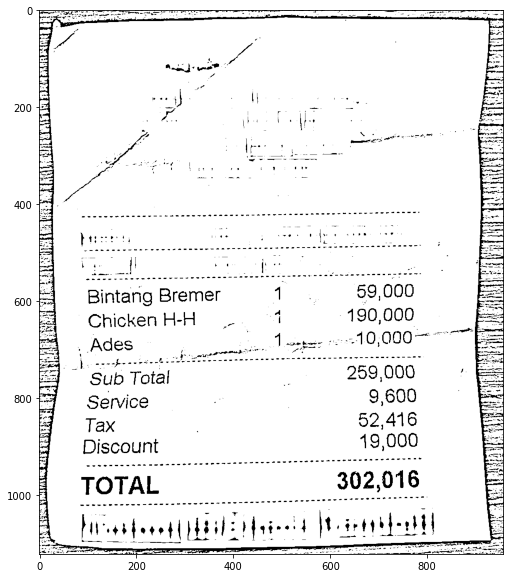

In [66]:
file_name1 = "result.png"
image = cv2.imread(file_name1, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

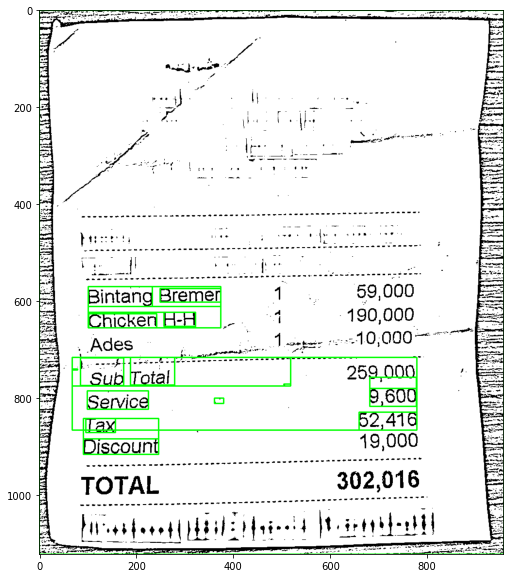

In [67]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [68]:
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(image, config=custom_config)
print(extracted_text)

mele :
3 reg} oo 4 ote. =
a : a jhe Pdf EE
Sooners ea ie, =
= Me el . c=
“4 Bintang Bremer 1. 59,000 =
4 Chicken H-H 4 190,000 a
= 5 Ades : cee 1 contests vo10,000—* cm =:
Bog. |. neve no beech  cULETIETT Tate eeeneatatersrccecsancssersenats SS
=4 Sub Total . 259,000 Be
=] Service - 9,600  &
qd Tax 62,416 =
4 Discount 19,000 fo
2 «TOTAL 302,016 =
A fivesters (bd friedd identi



In [69]:
#Lines to excluse on the receipt
exclusion_list = ["subtotal"]

#Words to ommit
remove_list = ["cee",  "contests"]

In [70]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['“4 Bintang Bremer 1. 59,000 =', '4 Chicken H-H 4 190,000 a', '= 5 Ades : cee 1 contests vo10,000—* cm =:', '=4 Sub Total . 259,000 Be', '=] Service - 9,600  &', 'qd Tax 62,416 =', '4 Discount 19,000 fo', '2 «TOTAL 302,016 =']


In [71]:
#Apply exclusion list
items = []
for eachLine in regex_line:
    found = False
    for exclude in exclusion_list:
        if exclude in eachLine.lower():
            found = True 
    if found == False:
        items.append(eachLine)
print(items)

['“4 Bintang Bremer 1. 59,000 =', '4 Chicken H-H 4 190,000 a', '= 5 Ades : cee 1 contests vo10,000—* cm =:', '=4 Sub Total . 259,000 Be', '=] Service - 9,600  &', 'qd Tax 62,416 =', '4 Discount 19,000 fo', '2 «TOTAL 302,016 =']


In [72]:
#Word ommit
new_item_list = []
for item in items:
    for subToRemove in remove_list:
        item = item.replace(subToRemove, "")
        item = item.replace(subToRemove.upper(), "")
    new_item_list.append(item)
print(new_item_list)

['“4 Bintang Bremer 1. 59,000 =', '4 Chicken H-H 4 190,000 a', '= 5 Ades :  1  vo10,000—* cm =:', '=4 Sub Total . 259,000 Be', '=] Service - 9,600  &', 'qd Tax 62,416 =', '4 Discount 19,000 fo', '2 «TOTAL 302,016 =']


In [73]:
#Food item cost regex
item_cost = []
for line in new_item_list:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            item_cost.append(possibleCost)
print(item_cost)

['59.000', '190.000', '10.000', '259.000', '9.600', '62.416', '19.000', '302.016']


In [74]:
#Remove cost price from food item
count = 0;
only_items = []
for item in new_item_list:
    only_alpha = ""
    for char in item:
        if char.isalpha() or char.isspace():
            only_alpha += char
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    only_items.append(only_alpha)
print(only_items)

['Bintang Bremer', 'Chicken HH', 'Ades     vo cm', 'Sub Total   Be', 'Service', 'qd Tax', 'Discount  fo', 'TOTAL']


In [75]:
#Removes 2 letter words from food item
#No core food item has two letters (Most cases)
finalitem = []
for item in only_items:
    # getting splits
    temp = item.split()

    # omitting K lengths
    res = [ele for ele in temp if len(ele) != 2]

    # joining result
    res = ' '.join(res)
    
    finalitem.append(res)
print(finalitem)

['Bintang Bremer', 'Chicken', 'Ades', 'Sub Total', 'Service', 'Tax', 'Discount', 'TOTAL']


In [76]:
#Taulate Food Item and Cost
t = PrettyTable(['Items', 'Cost'])
for counter in range (0,len(finalitem)):
    t.add_row([finalitem[counter], item_cost[counter]])
print(t)

+----------------+---------+
|     Items      |   Cost  |
+----------------+---------+
| Bintang Bremer |  59.000 |
|    Chicken     | 190.000 |
|      Ades      |  10.000 |
|   Sub Total    | 259.000 |
|    Service     |  9.600  |
|      Tax       |  62.416 |
|    Discount    |  19.000 |
|     TOTAL      | 302.016 |
+----------------+---------+


# **5 - Kesimpulan**

Berhasil mengambil dalam foto menggunakan OCR - Tesseract. Keakuratan  OCR tergantung pada jumlah karakter dikenali secara benar dibandingkan dengan jumlah karakter pada foto asli.

- **Character Error Rate (CER)**:

    - Number of Substitutions (S) = 1

    - Number of Deletions (D) = 2

    - Number of Insertions (I) = 0

    - Number of characters in reference text (N) = 97

  - **CER = 0.03%**

- **Word Error Rate (WER)**:

    - Number of Substitutions (S) = 1

    - Number of Deletions (D) = 1

    - Number of Insertions (I) = 0

    - Number of characters in reference text (N) = 16

    - **WER = 0.125%**


Lalu mengulangi perhitungan ini untuk semua pasangan output dan foto asli yang sesuai, dan mengambil rata-rata dari nilai-nilai ini untuk mendapatkan persentase CER dan WER keseluruhan.




